In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [36]:
data_df = pd.read_csv('Fraud (1).csv')
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [37]:
data_df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [6]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', 100)

In [7]:
#metric used for RandomForrestClassifier
RFC_METRIC = 'gini'

In [8]:
#number of estimators used for RandomForrestClassifier
NUM_ESTIMATORS = 100

In [10]:
#number of parallel jobs used for RandomForrestClassifier
NO_JOBS = 4

In [11]:
#TRAIN/VALIDATION/TEST SPLIT
VALID_SIZE = 0.20 
TEST_SIZE = 0.20

In [12]:
#number of K-fold
NUMBER_KFOLDS = 5

In [13]:
RANDOM_STATE = 2018

MAX_ROUNDS = 1000 
EARLY_STOP = 50 
OPT_ROUNDS = 1000  
VERBOSE_EVAL = 50 

IS_LOCAL = False

details to the data

In [38]:
data_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# Check missing data

In [39]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# check data unbalance with respect with target value

In [40]:
temp = data_df["isFraud"].value_counts()
df = pd.DataFrame({'isFraud': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['isFraud'],y = df['values'],
    name="Credit Card Fraud isFraud - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud isFraud - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'isFraud', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='isFraud')

Only 8213 of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

# Data exploration

In [41]:
data_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

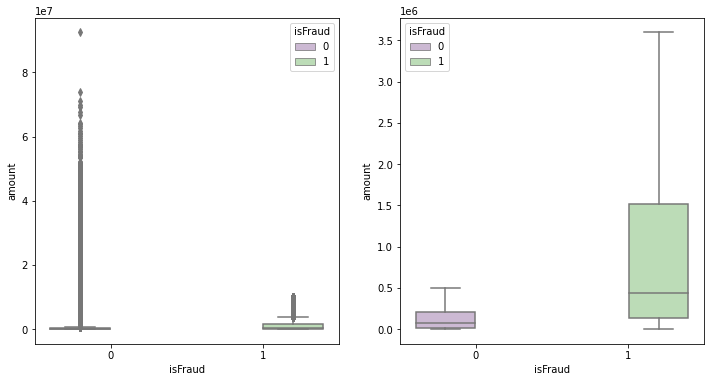

In [44]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="isFraud", y="amount", hue="isFraud",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="amount", hue="isFraud",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [45]:
tmp = data_df[['amount','isFraud']].copy()
class_0 = tmp.loc[tmp['isFraud'] == 0]['amount']
class_1 = tmp.loc[tmp['isFraud'] == 1]['amount']
class_0.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

In [47]:
class_1.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

In [49]:
fraud = data_df.loc[data_df['isFraud'] == 1]

trace = go.Scatter(
    x = fraud['step'],y = fraud['amount'],
    name="amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'step', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

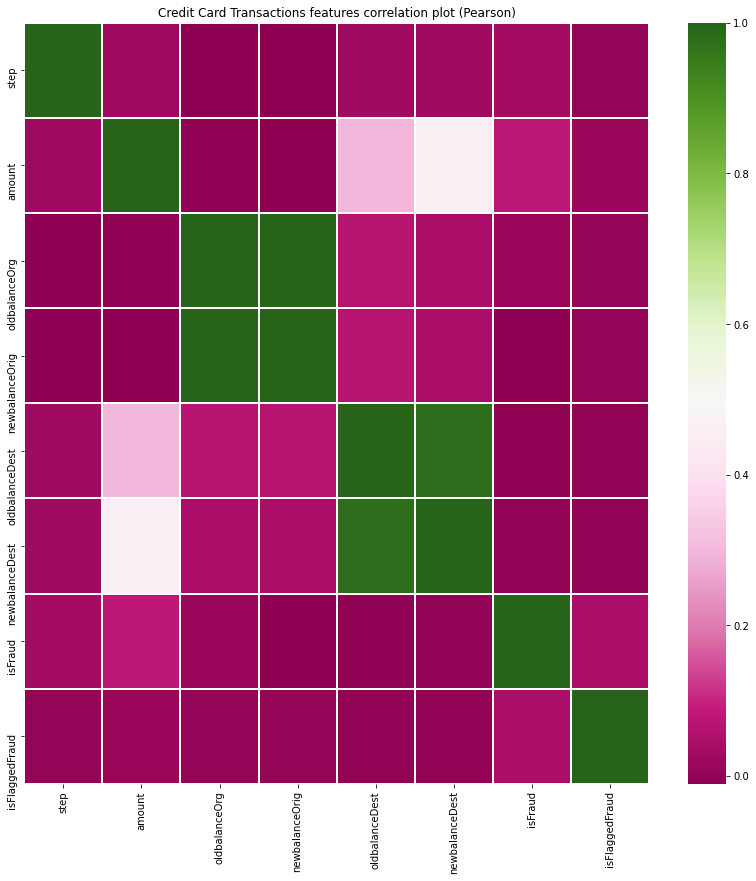

In [50]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="PiYG")
plt.show()

there is no notable correlation between features.
There are certain correlations between some of these features and oldbalanceOrg, newbalanceOrig

# Split data in train, test and validation set

In [53]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [56]:
data_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [60]:
target = 'isFraud'
predictors = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest', 'oldbalanceDest']

# I use RandomForestClassifier

In [61]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [62]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [63]:
preds = clf.predict(valid_df[predictors])

# Features importance

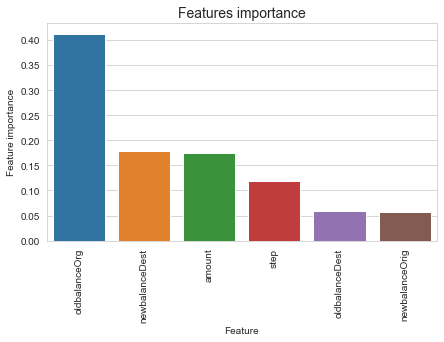

In [64]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

Confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data, so I use #Area under curve

# ROC-AUC score

In [65]:
roc_auc_score(valid_df[target].values, preds)

0.8565974302576902

I investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.

For prevention company should be adopt right threshold

After these action have been implemented This model is gives you the real time rate of fraud

# XGBoost

Train the model

In [67]:
import xgboost as xgb

In [68]:
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [69]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[14:59:26] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.58953	valid-auc:0.58855
[50]	train-auc:0.86616	valid-auc:0.86339
[100]	train-auc:0.91337	valid-auc:0.90878
[150]	train-auc:0.97086	valid-auc:0.96996
[200]	train-auc:0.98451	valid-auc:0.98611
[250]	train-auc:0.98818	valid-auc:0.99022
[300]	train-auc:0.98988	valid-auc:0.99177
[350]	train-auc:0.99130	valid-auc:0.99315
[400]	train-auc:0.99249	valid-auc:0.99423
[450]	train-auc:0.99344	valid-auc:0.99490
[500]	train-auc:0.99424	valid-auc:0.99560
[550]	train-auc:0.99474	valid-auc:0.99599
[600]	train-auc:0.99519	valid-auc:0.99641
[650]	train-auc:0.99574	valid-auc:0.99693
[700]	train-auc:0.99604	valid-auc:0.99729
[750]	train-auc:0.99639	valid-auc:0.99748
[800]

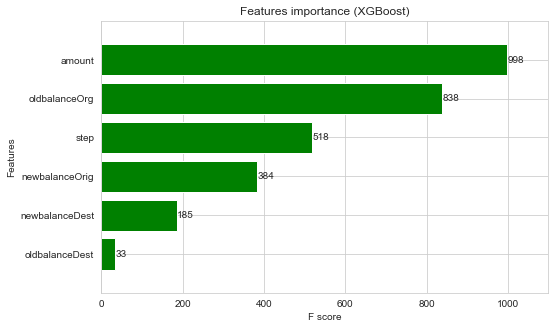

In [70]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

Predict test set

In [72]:
x_preds = model.predict(dtest)

In [73]:
roc_auc_score(test_df[target].values, x_preds)

0.9978283100774453

I just received 99.78% accuracy in our credit card fraud detection. This number should not be surprising as our data was balanced towards one class. The good thing that I have noticed from the Area under curve is that — my model is not overfitted.